In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import sys

from tqdm import tqdm_notebook

from nltk import ngrams

In [2]:
import itertools
from itertools import tee

import editdistance as ed

In [3]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [4]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

In [5]:
# Check randint
def generate_repeat(repeat_a, repeat_b):
    transition_pos = np.random.randint(0, len(repeat_a) + 1)
    return repeat_a[0:transition_pos] + repeat_b[transition_pos:]

In [6]:
class RepeatsDescr:
    def __init__(self, repeats):
        self.n = len(repeats)
        self.repeats = repeats
        self.repeat_to_n = dict(zip(self.repeats, np.arange(len(repeats))))
        self.n_to_repeat = dict(zip(np.arange(len(repeats)), self.repeats))
        self.mat = self._create_complementory_matrix()

    def add_repeat(self, repeat):
        self.repeats.append(repeat)
        self.repeat_to_n[repeat] = self.n
        self.n_to_repeat[self.n] = repeat
        self.n += 1
        self._update_complementory_matrix()
        
    def _create_complementory_matrix(self):
        mat = np.zeros((self.n, self.n))

        for r1, r2 in itertools.product(self.repeats, self.repeats):
            mat[self.repeat_to_n[r1]][self.repeat_to_n[r2]] = 1 - (ed.eval(r1,r2) / max(len(r1), len(r2)))
        return mat
    
    def _update_complementory_matrix(self):
        self.mat = np.pad(self.mat, ((0,1), (0,1)), mode = 'constant')
        
        for r in self.repeats:
            val = 1 - (ed.eval(r,repeats[-1]) / max(len(r), len(repeats[-1])))
            self.mat[self.repeat_to_n[r], self.repeat_to_n[repeats[-1]]] = val
            self.mat[self.repeat_to_n[repeats[-1]], self.repeat_to_n[r]] = val

In [7]:
repeats = ['aaaaaaaaaa',
           'aaaaaaaaab',
           'aaaaaaaabb']

repeats_descr = RepeatsDescr(repeats)

In [8]:
repeats_descr.add_repeat("aaaaaaabbb")

In [5]:
class Population:
    def _from_ip(
                 initial_population, 
                 primers_counts,
                 max_len = 10):
        max_len = max_len
        max_size = (sum(primers_counts.values()) + len(initial_population))
        
        p = np.ones((max_size, max_len)).astype(int) * -1
        
        pos = 0
        for arr in initial_population:
            j_pos = (max_len - len(arr)) // 2 + ((max_len - len(arr)) // 2) % 2
            p[pos, j_pos: j_pos + len(arr)] = arr
            pos += 1
        for k, v in primers_counts.items():
            j_pos = max_len  // 2 - (max_len // 2) % 2
            p[pos: pos + v, j_pos ] = k
            pos += v
        
        return Population(p)
    
    def __init__(self, p):
        self.p = p
        self.max_len = p.shape[1]
        self.max_size = p.shape[0]
        self._recalc_glue_mask()
    
    def __getitem__(self, key):
        return Population(self.p[key])
    
    def get_rep_pos_by_ind(self, ind):
        return (ind * 2 // self.p.shape[1], ind * 2 % self.p.shape[1])
    
    def get_rep_by_ind(self, ind):
        return self.p[:,::2].flatten()[ind]

    def _recalc_glue_mask(self):
        self.glue_mask = self.p[:, ::2].flatten() >= 0 

In [6]:
from copy import deepcopy

In [30]:
V = 'DEBUG_2'

In [112]:
p_list = [[-2, -2, 0,0, 0,1, 0, -2, -2], [-2, -2, 0,1, 0,5,0, -2, -2]]# + [[-2, -2, 0, -2, -2]] * 10
primers_num = {3:2}
p = Population._from_ip(p_list, primers_num, max_len=16)

In [37]:
p_list = [[-2, -2, 0,0, 0,1, 0,2, 0,3, 0,4, 0, -2, -2], [-2, -2, 0,1, 0,5, 0,6,0, -2, -2], [-2, -2, 0,1, 0,5, 0,6,0, -2, -2]]
primers_num = {0:100}
p = Population._from_ip(p_list, primers_num, max_len=16)

In [113]:
fp = deepcopy(p)
bp = deepcopy(p)

In [114]:
pcr = fast_PCR(fp, bp, repeats_descr)

In [115]:
%%time
for i in tqdm_notebook(range(5)):
    pcr.split_cylce()

A Jupyter Widget

CPU times: user 41.9 ms, sys: 4.03 ms, total: 45.9 ms
Wall time: 39.4 ms


In [116]:
pcr.fp.p

array([[-1, -1, -1, -1, -2, -2,  0,  0,  0,  1,  0, -2, -2, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  0,  5,  0, -2, -2, -1],
       [-1, -1, -1, -1, -2, -2,  0,  1,  0,  5,  0, -2, -2, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  0, -2, -2, -1, -1, -1]])

In [117]:
pcr.bp.p

array([[-1, -1, -1, -1, -2, -2,  0,  0,  0,  1,  0, -2, -2, -1, -1, -1],
       [-1, -1, -1, -1, -2, -2,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -2,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -2, -2,  0,  1,  0,  5,  0, -2, -2, -1, -1, -1]])

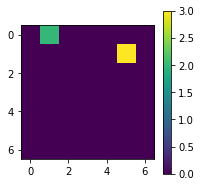

In [118]:
plot_gr(pcr.to_graph(7), s = 3, log = 0)

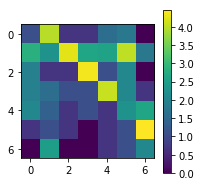

In [920]:
plot_gr(pcr.to_graph(7), s = 3, log = 1)

In [910]:
p_list

[[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0], [0, 1, 0, 5, 0, 6, 0]]

In [762]:
pcr.glue_f_to_b(2,3,0,2)

In [763]:
pcr.glue_b_to_f(1,4, 2,1)

In [688]:
if bj > 0 and self.bp.p[bi][bj - 1] == -1:
    copy_part = self.fp.p[fi][:fj][self.fp.p[fi][:fj] != -1][fj - bj:fj]
    self.fp.p[bi][bj - copy_part.shape[0]:bj] = copy_part

NameError: name 'bj' is not defined

In [641]:
pcr.print_glue_points()

1 2 ;  0 2 ;  0 4
2 1 ;  0 4 ;  0 2
5 6 ;  1 2 ;  1 4
6 5 ;  1 4 ;  1 2


In [612]:
pcr._amplify()

1 17 ;  0 2 ;  3 4
3 22 ;  0 6 ;  4 4
6 6 ;  1 2 ;  1 2
7 8 ;  1 4 ;  1 6
8 7 ;  1 6 ;  1 4
17 1 ;  3 4 ;  0 2
22 3 ;  4 4 ;  0 6
27 27 ;  5 4 ;  5 4


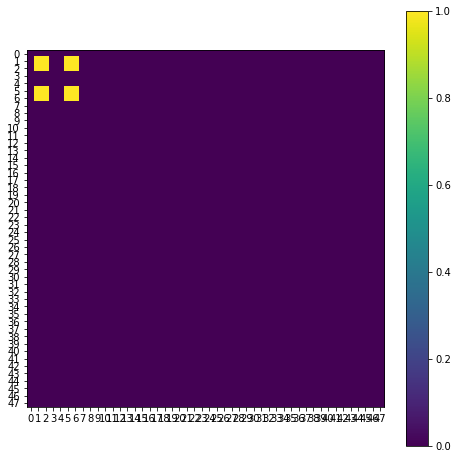

In [789]:
pcr._annealing()
plot_gr(pcr.comp_mat, s  = 8, all_ticks=1)

## TRY REAL

In [13]:
repeats_descr.mat = repeats_descr.mat**1.6

In [48]:
repeats_descr.mat[0][0] = 0.8
repeats_descr.mat[1][1] = 0.1

In [367]:
repeats_descr.mat

array([[0.8, 0.6, 0.9, 0.8, 0.9, 0.8],
       [0.6, 0.8, 0.8, 0.9, 0.8, 0.9],
       [0.9, 0.8, 0.9, 0.8, 0.8, 0.8],
       [0.8, 0.9, 0.8, 0.9, 0.8, 0.8],
       [0.9, 0.8, 0.8, 0.8, 0.8, 0.8],
       [0.8, 0.9, 0.8, 0.8, 0.8, 0.8]])

In [366]:
repeats_descr.mat[0][0] = 0.8
repeats_descr.mat[1][1] = 0.8
repeats_descr.mat[0][1] = 0.6
repeats_descr.mat[1][0] = 0.6

In [509]:
BIG_CONST = 300

In [571]:
repeats_descr.mat = np.array(
    [[0.8, 0.6, 0.1, 0.1, 0.1, 0.1],
     [0.6, 0.8, 0.8, 0.9, 0.8, 0.9],
     [0.1, 0.8, 0.9, 0.8, 0.8, 0.8],
     [0.1, 0.9, 0.8, 0.9, 0.8, 0.8],
     [0.1, 0.8, 0.8, 0.8, 0.8, 0.8],
     [0.1, 0.9, 0.8, 0.8, 0.8, 0.8]
    ])

In [573]:
p_list_0 = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
            [[4, 2, 5, 7, 11] for i in range(5)] + \
               [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34] for i in range(1)] + \
               [[1, 20, 22, 23, 21, 29] for i in range(1)]

In [587]:
p_list[0]

[-2,
 -2,
 1,
 1,
 1,
 0,
 1,
 3,
 0,
 6,
 0,
 8,
 0,
 9,
 0,
 10,
 0,
 13,
 0,
 14,
 0,
 15,
 0,
 17,
 0,
 12,
 0,
 16,
 0,
 -2,
 -2]

In [574]:
p_list = []

for p in p_list_0:
    p_ = [-2, -2]
    for c in p:
        p_.append(0)
        p_.append(c)
    p_.append(0)
    
    p_.extend([-2,-2])
    
    p_list.append(p_)

In [575]:
for i in range(5):
    p_list[i][2] = 1
    p_list[i][4] = 1
    p_list[i][6] = 1

In [576]:
pfl = [x for x in p_list]
pfl.extend([[2], [3]] * (50 * 20))

pbl = [x for x in p_list]
pbl.extend([[4]] * (33 * 20))
pbl.extend([[5]] * (67 * 20))

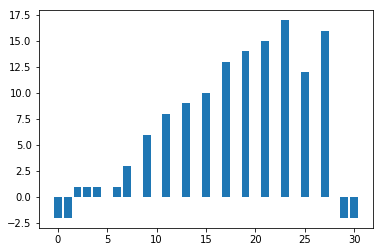

In [577]:
_ = plt.bar(np.arange(len(p_list[0])), p_list[0])

In [578]:
#p_list = [[0,0, 0,1, 0,2, 0,3, 0,4, 0], [0,1, 0,5, 0,6,0]]
primers_num = {0:0, 1:0}
p = Population._from_ip(p_list, primers_num, max_len=64)

In [579]:
fp = Population._from_ip(pfl, primers_num, max_len=64)
bp = Population._from_ip(pbl, primers_num, max_len=64)

In [580]:
pcr = fast_PCR(fp,  bp, repeats_descr)

In [581]:
products = []
total = []
ratios = []
for i in tqdm_notebook(range(25)):
    products.append(((pcr.fp.p != -1).sum(1) != 1).sum())
    total.append((pcr.fp.p != -1).astype(int).sum())
    pcr.split_cylce()
    
    gr = pcr.to_graph(35)
    ratios.append(gr[:18,:18].sum() / gr[18:,18:].sum())
    print(ratios[-1])

A Jupyter Widget

5.333333333333333
4.722222222222222
4.722222222222222
5.361111111111111
6.5
7.388888888888889
6.630434782608695
7.065217391304348
6.481481481481482
7.092592592592593
7.555555555555555
8.296296296296296
8.24561403508772
9.140350877192983
9.64406779661017
10.066666666666666
9.042857142857143
8.430379746835444
7.536842105263158
8.2
7.866666666666666
8.028571428571428
7.75
8.233333333333333
8.783333333333333



In [582]:
for i in tqdm_notebook(range(2)):
    products.append(((pcr.fp.p != -1).sum(1) != 1).sum())
    total.append((pcr.fp.p != -1).astype(int).sum())
    pcr.split_cylce()
    
    gr = pcr.to_graph(35)
    ratios.append(gr[:18,:18].sum() / gr[18:,18:].sum())
    print(ratios[-1])

A Jupyter Widget

8.90983606557377
9.69672131147541



In [528]:
ratios_1 = [x for x in ratios]

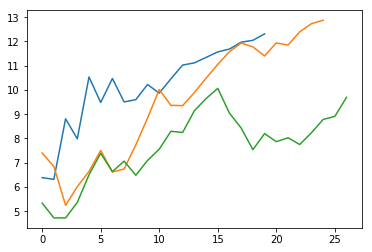

In [583]:
plt.plot(ratios_0)
plt.plot(ratios_1)
plt.plot(ratios)

In [584]:
gr = pcr.to_graph(35)

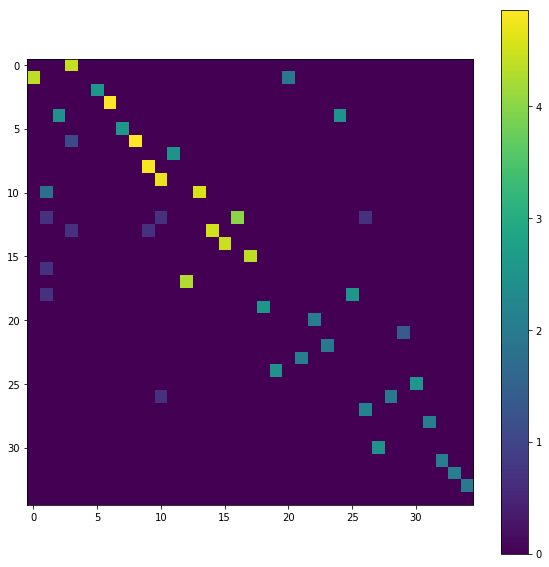

In [585]:
plot_gr(pcr.to_graph(35), log = 1)

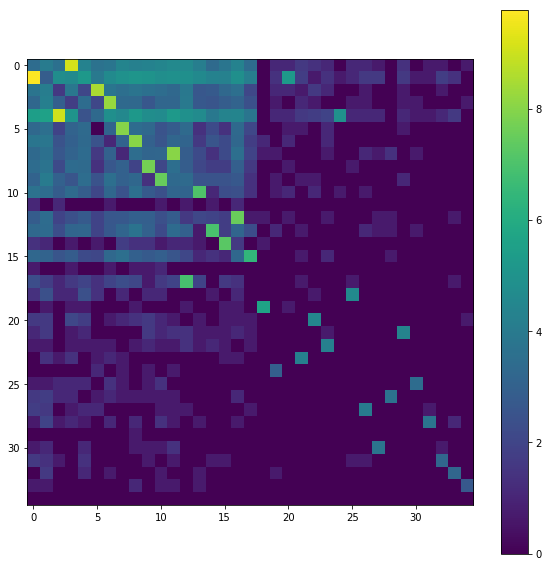

In [382]:
gr0 = np.load("../../data/graphs/ES3_22.npy")[:35,:35]
plot_gr(gr0, log = 1)

In [505]:
gr[:18,:18].sum() / gr[18:,18:].sum()

12.311839911061702

In [506]:
gr0[:18,:18].sum() / gr0[18:,18:].sum()

73.76393110435663

In [589]:
gr0.max(1).astype(int)

array([ 9224, 17455,  4956,  3815,  8568,  2941,  3022,  3059,  2268,
        1809,  1174,     2,  1845,  1067,  1432,   619,     2,  1019,
         102,   289,    86,    77,    69,    69,    18,    30,    38,
          52,    42,     1,    42,    24,    24,    14,     0])

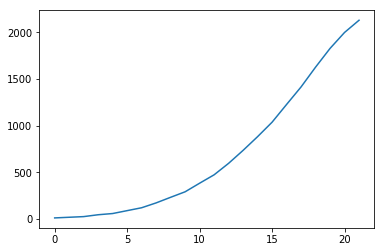

In [485]:
plt.plot(products)
plt.show()

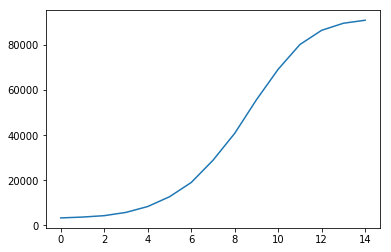

In [437]:
plt.plot(total)
plt.show()

(array([115., 172., 159.,  92., 115., 101.,  27.,  20.,   6.,   5.]),
 array([ 1. ,  6.4, 11.8, 17.2, 22.6, 28. , 33.4, 38.8, 44.2, 49.6, 55. ]),
 <a list of 10 Patch objects>)

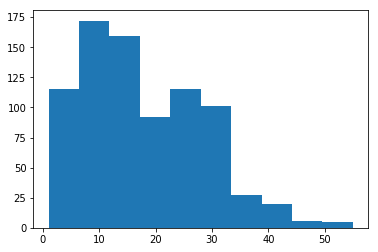

In [118]:
plt.hist((pcr.fp.p != -1).sum(1), bins = 10)

In [119]:
gr = pcr.to_graph(35)

<Container object of 35 artists>

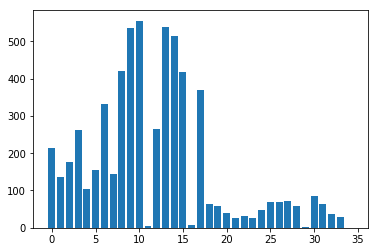

In [120]:
plt.bar(np.arange(35), gr.max(1))

In [121]:
gr[18:].max()

85.0

In [122]:
gr[:17].max()

555.0

In [107]:
gr[0].max()

368.0

In [190]:
343 / 27

12.703703703703704

## ES1

In [214]:
def run():
    nrs = []
    ps = []
    params = []
    
    for coef in [1, 2, 4]:
        print(coef)
        p_list = []

        for p in p_list_0:
            p_ = [-2, -2]
            for c in p:
                p_.append(0)
                p_.append(c)
            p_.append(0)
            p_.extend([-2,-2])
            p_list.append(p_)
        for i in range(10):
            p_list[i][2] = 1
            p_list[i][-3] = 1
        
        pfl = [x for x in p_list]
        pfl.extend([[2], [3]] * 50 * coef)

        pbl = [x for x in p_list]
        pbl.extend([[4]] * 33 * coef)
        pbl.extend([[5]] * 67 * coef)
        
        primers_num = {0:0, 1:0}
        p = Population._from_ip(p_list, primers_num, max_len=64)
        
        fp = Population._from_ip(pfl, {}, max_len=64)
        bp = Population._from_ip(pbl, {}, max_len=64)
        
        pcr = fast_PCR(fp,  bp, repeats_descr)
        
        products = []
        total = []
        noise_ratio = []
        for i in tqdm_notebook(range(20)):
            products.append(((pcr.fp.p != -1).sum(1) != 1).sum())
            total.append((pcr.fp.p != -1).astype(int).sum())
            pcr.split_cylce()
            gr = pcr.to_graph(19)
            noise_ratio.append(gr[grC != 1].sum() / gr[grC == 1].sum())
            
        nrs.append(noise_ratio)
        ps.append(products)
        params.append(coef)
    
    return nrs, ps, params

In [7]:
class fast_PCR:
    def __init__(self, fp, bp, mat):
        self.fp = fp
        self.bp = bp
        self.mat = mat

    def as_part(self, pcr, f_indexes, b_indexes):
        self.fp = pcr.fp[f_indexes]
        self.bp = pcr.bp[b_indexes]
        
    def from_list_of_pcrs(self, pcr_list):
        self.fp = Population(np.vstack([x.fp.p for x in pcr_list]))
        self.bp = Population(np.vstack([x.bp.p for x in pcr_list]))
        
    def _calculate_complementary_matrix(self):
        self.fp._recalc_glue_mask()
        self.bp._recalc_glue_mask()
        self.comp_mat = np.zeros((self.fp.glue_mask.sum(), self.bp.glue_mask.sum()))
        self.f_match = np.arange(self.fp.glue_mask.shape[0])[self.fp.glue_mask]
        self.b_match = np.arange(self.bp.glue_mask.shape[0])[self.bp.glue_mask]
        
        for i in range(self.comp_mat.shape[0]):
            for j in range(self.comp_mat.shape[1]):
                r_f = self.fp.get_rep_by_ind(self.f_match[i])
                r_b = self.bp.get_rep_by_ind(self.b_match[j])
                
                if r_f >= 0 and r_b >= 0:
                    self.comp_mat[i][j] = self.mat[r_f, r_b]
                
    def _annealing(self):
        self._calculate_complementary_matrix()
        self.anneal = np.zeros_like(self.comp_mat)
        indexes = np.arange(self.anneal.shape[0])
        np.random.shuffle(indexes)
        
        self.rows_mean = BIG_CONST# np.mean(self.comp_mat.sum(1)) 
        
        for i in indexes:
            row = self.comp_mat[i]
            if row.sum() != 0:
                if np.random.rand() < row.sum() / (row.sum() + self.rows_mean):
                    j = np.random.choice(np.arange(row.shape[0]), size = 1, p = row.astype(float) / row.sum())

                    self.anneal[i, j] = 1
                    self.comp_mat[i] = 0
                    self.comp_mat[:, j] = 0
               
            
    def _amplify(self):
        
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(self.f_match[f])
            bi, bj = self.bp.get_rep_pos_by_ind(self.b_match[b])
#             print(self, f, b, '; ', fi, fj, '; ', bi, bj)
#             print("forw\n", self.fp.p.astype(int))
#             print("backw\n", self.bp.p.astype(int))
            self.restore_f(fi, fj, bi, bj)
            self.restore_b(fi, fj, bi, bj)
            
            
    def restore_f(self, fi, fj, bi, bj):
        if self.fp.p[fi][fj + 1] == -1 and fj + 2 != self.fp.max_len:# and (self.fp.p[fi]).sum() < 64:
            copy_part = self.bp.p[bi][bj:][: self.fp.max_len - fj]#[self.bp.p[bi][bj:] != -1]
            copy_part = copy_part[copy_part != -1]
            self.fp.p[fi][fj:fj + copy_part.shape[0]] = copy_part
#             if fj + copy_part.shape[0] > 16:
#                 print(fi, fj, bi, bj, copy_part)
#             if fj < 8:
#                 print(fi, fj, bi, bj, copy_part)
    
    def restore_b(self, fi, fj, bi, bj):
        #print(fi, fj, bi, bj)
        if bj > 0 and self.bp.p[bi][bj - 1] == -1:# and (self.bp.p[bi]).sum() < 64:
            copy_part = self.fp.p[fi][:fj + 1][fj - bj :fj + 1]#[self.fp.p[fi][:fj] != -1]
            copy_part = copy_part[copy_part != -1]
            self.bp.p[bi][bj - copy_part.shape[0] + 1 :bj + 1] = copy_part
            
            
    def print_glue_points(self):
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(f)
            bi, bj = self.bp.get_rep_pos_by_ind(b)
            #print(f, b, '; ', fi, fj, '; ', bi, bj)
            
    
    def cycle(self):
        self._annealing()
        self._amplify()
        #self.fp, self.bp = self.bp, self.fp
        
    def split_cylce(self, n= None):
        if n is None:
            self.n  = max(self.fp.p.shape[0], self.bp.p.shape[0]) // 20 + 1
        else: self.n = n
            
        self.f_indexes = np.arange(self.fp.p.shape[0])
        self.b_indexes = np.arange(self.bp.p.shape[0])
        
        np.random.shuffle(self.f_indexes)
        np.random.shuffle(self.b_indexes)
        
        self.pcr_list = []
        
        for f_i, b_i in zip(np.array_split(self.f_indexes, self.n), np.array_split(self.b_indexes, self.n)):
            pcr_part = fast_PCR(self.fp[f_i], self.bp[b_i], self.mat)
            pcr_part.cycle()
            self.pcr_list.append(pcr_part)
        
        self.from_list_of_pcrs(self.pcr_list)
            
        
    def to_pairs(self):
        all_pairs = {}
        for product in np.vstack((self.fp.p[:, 1::2],self.bp.p[:, 1::2])):
            for a,b in zip(product, product[1:]):
                if a!= -1 and b!= -1:
                    if (a,b) in all_pairs:
                        all_pairs[(a,b)] += 1
                    else:
                        all_pairs[(a,b)] = 1
        return all_pairs
    
    def to_graph(self, sp_num):
        gr = np.zeros((sp_num, sp_num))
        
        for p, n in self.to_pairs().items():
            if p[0] >= 0 and p[1] >= 0:
                gr[p[0]][p[1]] = n
        return gr
        

In [162]:
nrs, ps, params = run()

1


A Jupyter Widget


2


A Jupyter Widget


4


A Jupyter Widget


8


A Jupyter Widget

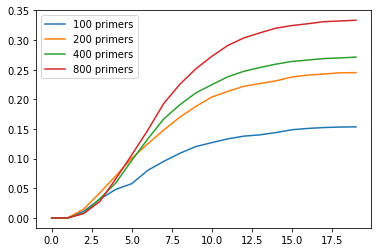

In [169]:
for c, nr in zip(params, nrs):
    plt.plot(nr, label = str(c * 100) + " primers")
plt.legend()

In [203]:
p_list_0 = [[x for x in range(13)] for i in range(5)] +\
           [[x for x in range(13, 19)] for i in range(5) ]

In [9]:
# repeats_descr.mat = np.ones((6,6))*0.7
# repeats_descr.mat[0][1] = 0.6
# repeats_descr.mat[1][0] = 0.6

# repeats_descr.mat = np.array([[0.7, 0.6, 0.9, 0.8, 0.9, 0.8],
#  [0.6, 0.7, 0.8, 0.9, 0.8, 0.9],
#  [0.9, 0.8, 0.9, 0.8, 0.8, 0.8],
#  [0.8, 0.9, 0.8, 0.9, 0.8, 0.8],
#  [0.9, 0.8, 0.8, 0.8, 0.8, 0.8],
#  [0.8, 0.9, 0.8, 0.8, 0.8, 0.8]
# ])
mat = np.array(
    [[0.1, 0.05, 0.9, 0.8, 0.9, 0.8],
     [0.05, 0.1, 0.8, 0.9, 0.8, 0.9],
     [0.9, 0.8, 0.9, 0.8, 0.8, 0.8],
     [0.8, 0.9, 0.8, 0.9, 0.8, 0.8],
     [0.9, 0.8, 0.8, 0.8, 0.8, 0.8],
     [0.8, 0.9, 0.8, 0.8, 0.8, 0.8]
    ])

BIG_CONST = 30

In [11]:
mat

array([[0.1 , 0.05, 0.9 , 0.8 , 0.9 , 0.8 ],
       [0.05, 0.1 , 0.8 , 0.9 , 0.8 , 0.9 ],
       [0.9 , 0.8 , 0.9 , 0.8 , 0.8 , 0.8 ],
       [0.8 , 0.9 , 0.8 , 0.9 , 0.8 , 0.8 ],
       [0.9 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 ],
       [0.8 , 0.9 , 0.8 , 0.8 , 0.8 , 0.8 ]])

In [12]:
p_list_0 = [[9,8,2,3,12,17,16,15,13,14,11,10,18] for i in range(5)] + \
            [[7,5,6,4,0,1] for i in range(5)]

In [13]:
p_list = []

for p in p_list_0:
    p_ = [-2, -2]
    for c in p:
        p_.append(0)
        p_.append(c)
    p_.append(0)
    p_.extend([-2,-2])
    p_list.append(p_)

In [14]:
for i in range(10):
    p_list[i][2] = 1
    p_list[i][-3] = 1
#     p_list[i][4] = 1
#     p_list[i][6] = 1

In [15]:
pfl = [x for x in p_list]
pfl.extend([[2], [3]] * 50)

pbl = [x for x in p_list]
pbl.extend([[4]] * 33)
pbl.extend([[5]] * 67)

In [326]:
#p_list = [[0,0, 0,1, 0,2, 0,3, 0,4, 0], [0,1, 0,5, 0,6,0]]
# primers_num = {0:0, 1:0}
p = Population._from_ip(p_list, {primers_num}, max_len=64)

In [16]:
fp = Population._from_ip(pfl, {}, max_len=64)
bp = Population._from_ip(pbl, {}, max_len=64)

In [17]:
pcr = fast_PCR(fp,  bp, mat)

In [20]:
products = []
total = []
noise_ratio = []
for i in tqdm_notebook(range(10)):
    products.append(((pcr.fp.p != -1).sum(1) != 1).sum())
    total.append((pcr.fp.p != -1).astype(int).sum())
    pcr.split_cylce()
    gr = pcr.to_graph(19)
    #noise_ratio.append(gr[grC != 1].sum() / gr[grC == 1].sum())

A Jupyter Widget

In [342]:
pcr.split_cylce()
gr = pcr.to_graph(19)
print(gr[grC != 1].sum() / gr[grC == 1].sum())

0.06352261790182868


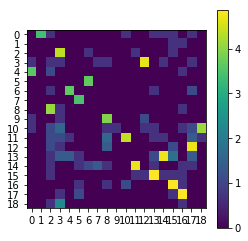

In [21]:
plot_gr(pcr.to_graph(19), all_ticks=1, log = 1, s = 4)

In [242]:
#noise_ratio_400_0205 = [x for x in noise_ratio]
#noise_ratio_1200_0205 = [x for x in noise_ratio]
#noise_ratio_400_0002_C = [x for x in noise_ratio]
noise_ratio_100_0002_C = [x for x in noise_ratio]

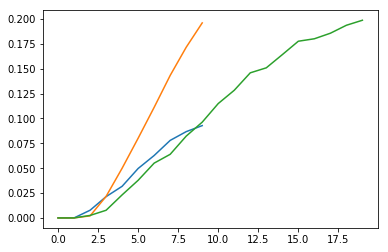

In [319]:
# plt.plot(noise_ratio_400_0205)
# plt.plot(noise_ratio_1200_0205)
plt.plot(noise_ratio_100_0002_C)
plt.plot(noise_ratio_400_0002_C)
plt.plot(noise_ratio)

In [229]:
for i in range(20):
    print(pcr.pcr_list[i].rows_mean)

30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30


In [267]:
pcr.split_cylce()

In [286]:
(pcr.fp.p[:,::2][:, :32] == -1).sum(1) 

array([32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 24, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       24, 32, 32, 32, 32, 24, 32, 32, 32, 28, 32, 32, 32, 32, 32, 28, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32])

In [287]:
(pcr.bp.p[:, ::2][:, 32:] == -1).sum(1)

array([31, 31, 31, 31, 31, 31, 31, 31, 24, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 27, 31, 31, 24, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 27, 31,
       31, 31, 31, 24, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 24,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 27, 27, 31, 31, 31, 31, 31, 31, 31, 27, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 24])

In [280]:
pcr.bp.p[::2]

(55, 128)

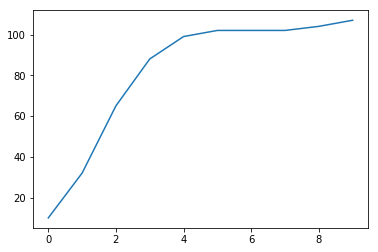

In [309]:
plt.plot(products)

In [454]:
noise_ratio_600_00 = [x for x in noise_ratio]

Text(0,0.5,'Ratio of wrong edges')

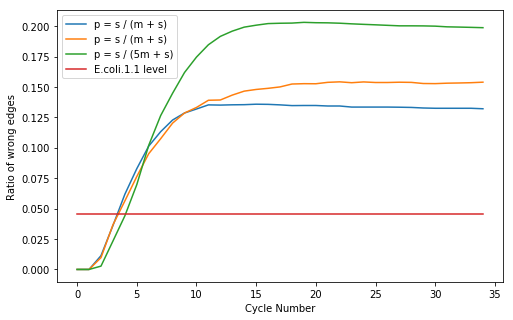

In [455]:
plt.figure(figsize=(8,5))
plt.plot(noise_ratio_200_00, label = 'p = s / (m + s)')
plt.plot(noise_ratio_200_02, label = 'p = s / (m + s)')
plt.plot(noise_ratio_600_00, label = 'p = s / (5m + s)')
# plt.plot(noise_ratio_200_05, label = 'p = s / (0.5m + s)')

plt.plot([1/22]*35, label = 'E.coli.1.1 level')


plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Ratio of wrong edges")
# plt.plot(noise_ratio_200_less_connections)
# plt.plot(noise_ratio_400_less_connections)

In [73]:
rp = pcr.fp.p[:,::2]

In [79]:
(rp == 3).sum()

0

In [483]:
pcr.bp.p[12:,65:].shape

(598, 63)

In [131]:
(pcr.fp.p[:,::2] == 3).sum()

0

In [135]:
(pcr.bp.p[:,::2] == 5).sum()

36

In [485]:
 63 * 598

37674

In [ ]:
plt.plot(products)

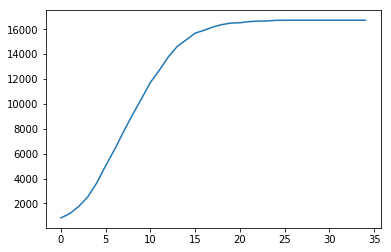

In [457]:
plt.plot(total)

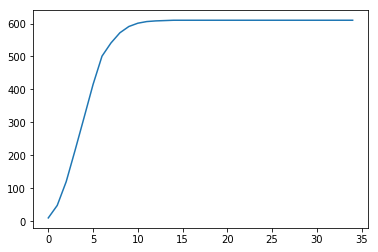

In [456]:
plt.plot(products)

Text(0,0.5,'Ratio of wrong edges')

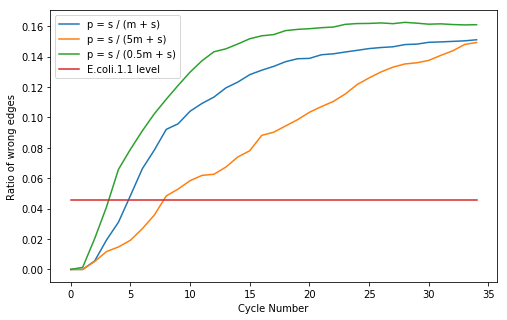

In [409]:
plt.figure(figsize=(8,5))
plt.plot(noise_ratio_200_1, label = 'p = s / (m + s)')
plt.plot(noise_ratio_200_5, label = 'p = s / (5m + s)')
plt.plot(noise_ratio_200_05, label = 'p = s / (0.5m + s)')

plt.plot([1/22]*35, label = 'E.coli.1.1 level')


plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Ratio of wrong edges")
# plt.plot(noise_ratio_200_less_connections)
# plt.plot(noise_ratio_400_less_connections)

Text(0,0.5,'Ratio of wrong edges')

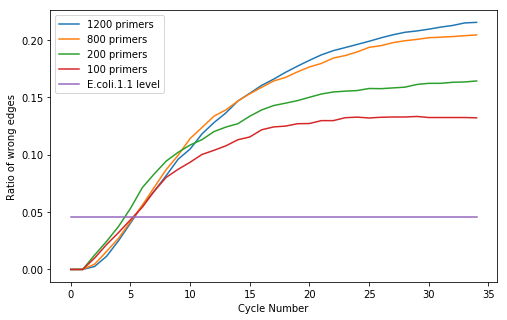

In [380]:
plt.figure(figsize=(8,5))
plt.plot(noise_ratio_1200, label = '1200 primers')
plt.plot(noise_ratio_800, label = '800 primers')

plt.plot(noise_ratio_200, label = '200 primers')
plt.plot(noise_ratio_100, label = '100 primers')

plt.plot([1/22]*35, label = 'E.coli.1.1 level')


plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Ratio of wrong edges")
# plt.plot(noise_ratio_200_less_connections)
# plt.plot(noise_ratio_400_less_connections)

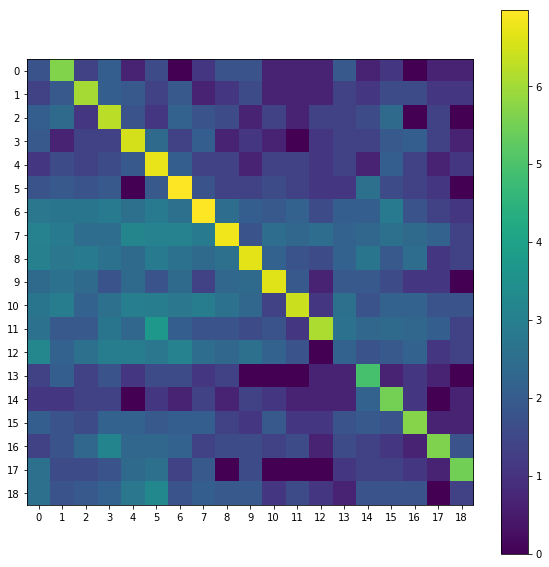

In [211]:
plot_gr(pcr.to_graph(19), all_ticks=1, log = 1)

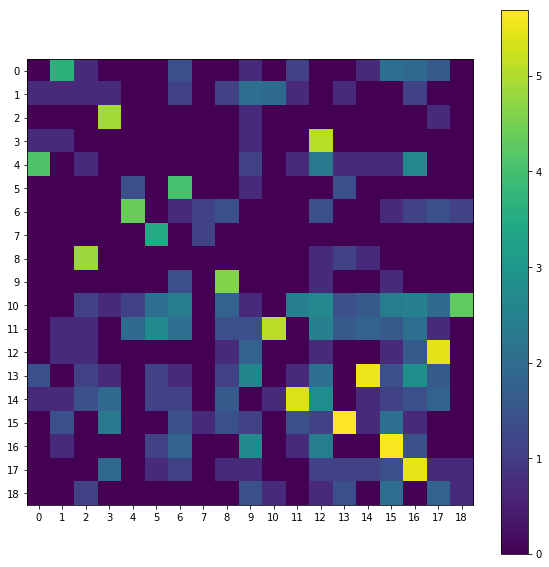

In [320]:
plot_gr(pcr.to_graph(19), all_ticks=1, log = 1)

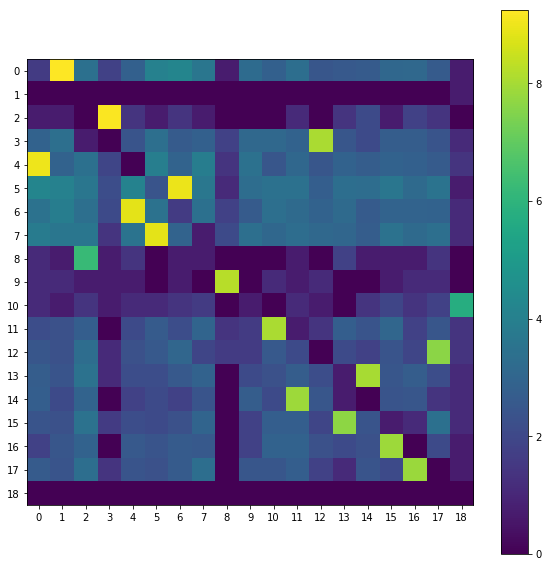

In [175]:
plot_gr(np.load("../../data/graphs/ES1.npy")[:19, :19], all_ticks=1, log = 1)

In [224]:
gr = pcr.to_graph(19)
gr0 = np.load("../../data/graphs/ES1.npy")[:19, :19]

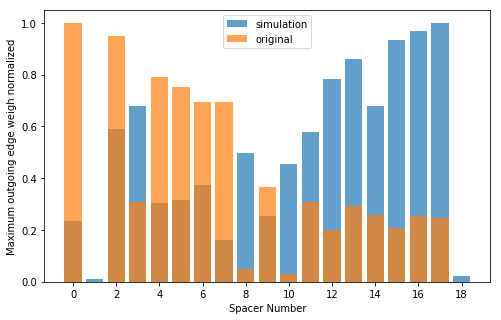

In [255]:
plt.figure(figsize = (8,5))
plt.bar(np.arange(19), gr.max(1) / gr.max(), alpha = 0.7, label = 'simulation')
plt.bar(np.arange(19), gr0.max(1) / gr0.max() , alpha = 0.7, label = 'original')
_ = plt.xticks(np.arange(0,19,2)) 
plt.xlabel("Spacer Number")
plt.ylabel("Maximum outgoing edge weigh normalized")
plt.legend()

Text(0,0.5,'Maximum incoming edge weigh normalized')

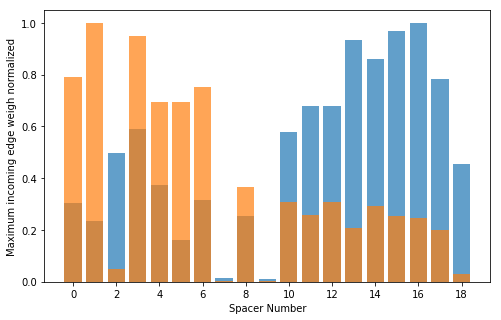

In [257]:
plt.figure(figsize = (8,5))
plt.bar(np.arange(19), gr.max(0) / gr.max(), alpha = 0.7, label = 'simulation')
plt.bar(np.arange(19), gr0.max(0) / gr0.max() , alpha = 0.7, label = 'oroginal')
_ = plt.xticks(np.arange(0,19,2)) 
plt.xlabel("Spacer Number")
plt.ylabel("Maximum incoming edge weigh normalized")

In [55]:
grC = np.zeros((19,19))
for a,b in zip(p_list_0[0], p_list_0[1][1:]):
    grC[a,b] = 1
for a,b in zip(p_list_0[9], p_list_0[9][1:]):
    grC[a,b] = 1

In [56]:
gr[grC == 1].sum() / gr[grC != 1].sum()

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


inf

In [57]:
gr0[grC == 1].sum() / gr0[grC != 1].sum()

NameError: name 'gr0' is not defined

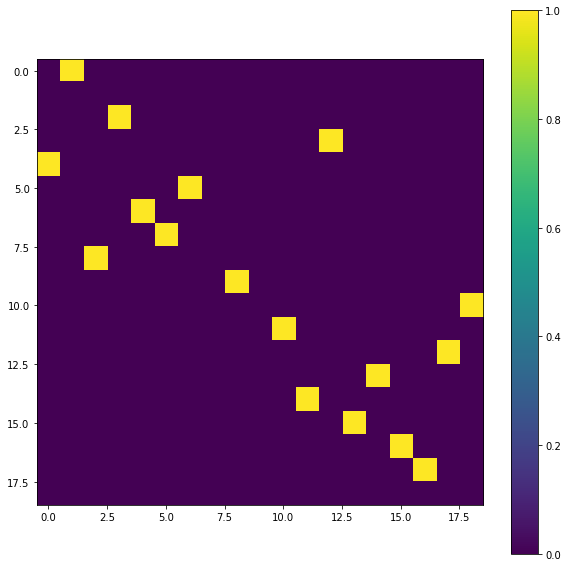

In [58]:
plot_gr(grC)

In [298]:
1 / 22 

0.045454545454545456

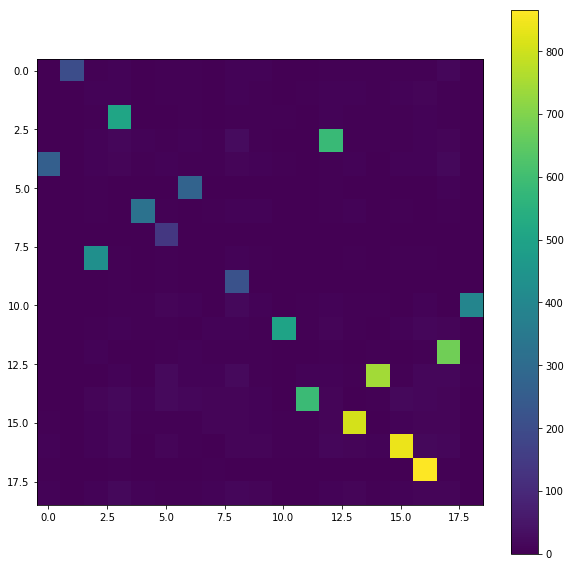

In [266]:
plot_gr(pcr.to_graph(19))

In [277]:
pcr.fp.p[:, 64]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [278]:
fp.p[:, 64]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,

In [322]:
gr0.max(1)

array([1.0311e+04, 1.0000e+00, 9.8050e+03, 3.1970e+03, 8.1470e+03,
       7.7530e+03, 7.1440e+03, 7.1760e+03, 5.0400e+02, 3.7630e+03,
       3.2000e+02, 3.1660e+03, 2.0670e+03, 3.0260e+03, 2.6480e+03,
       2.1360e+03, 2.6270e+03, 2.5500e+03, 0.0000e+00])

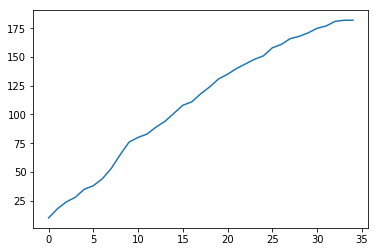

In [337]:
plt.plot(products)
plt.show()

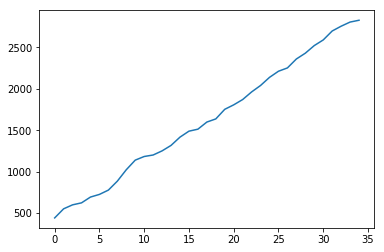

In [338]:
plt.plot(total)
plt.show()

In [137]:
np.load("../../data/graphs/ES1.npy")[10]

array([  2.,   1.,   3.,   1.,   2.,   2.,   3.,   4.,   0.,   1.,   0.,
         2.,   1.,   0.,   3.,   6.,   3.,   5., 320.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])